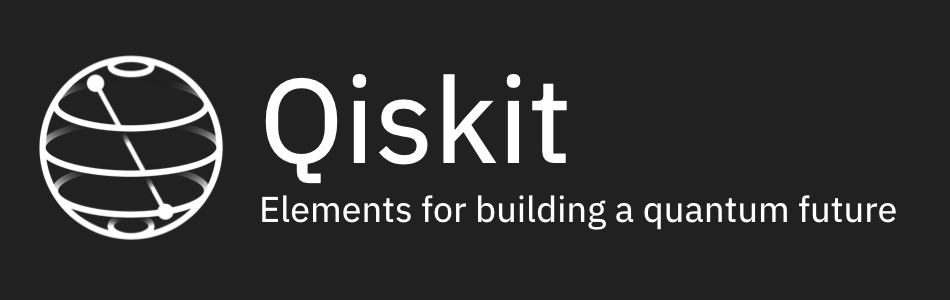

# Qiskit Aer: Pulse simulation of two qubits using a Duffing oscillator model

## Introduction

This notebook shows how to use the Qiskit Aer pulse simulator, which simulates experiments specified as pulse `Schedule` objects at the Hamiltonian level. The simulator solves the Schrodinger equation for a specified Hamiltonian model and pulse `Schedule` using the `zvode` method available through `scipy`, in the frame of the drift Hamiltonian.

In particular, in each section of this tutorial we will: 
1. Construct a model of a two qubit superconducting system.
2. Calibrate $\pi$ pulses on each qubit.
3. Observe cross-resonance oscillations when driving qubit 1 with target qubit 0.

These steps are expanded on below.

### 1. Duffing oscillator model

To simulate a physical system, it is necessary to specify a model. In this notebook, we will model superconducting qubits as a collection of *Duffing oscillators*. The model is specified in terms of the following parameters:

-  Each Duffing oscillator is specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which result in the Hamiltonian terms:
\begin{equation}
    \pi(2\nu - \alpha)a^\dagger a + \pi \alpha (a^\dagger a)^2 + 2 \pi r (a + a^\dagger) \times D(t),
\end{equation}
where $D(t)$ is the signal on the drive channel for the qubit, and $a^\dagger$ and $a$ are, respectively, the creation and annihilation operators for the qubit.
-  A coupling between a pair of oscillators $(l,k)$ is specified by the coupling strength $J$, resulting in an exchange coupling term:
\begin{equation}
    2 \pi J (a_l \otimes a_k^\dagger + a_l^\dagger \otimes a_k),
\end{equation}
where the subscript denotes which qubit the operators act on.
- Additionally, for numerical simulation, it is necessary to specify a cutoff dimension; the Duffing oscillator model is *infinite dimensional*, and computer simulation requires restriction of the operators to a finite dimensional subspace.

**In the code:** We will define a model of the above form for two coupled qubits using the helper function `duffing_system_model`.

### 2. $\pi$ pulse calibration

Once the model is defined, we will calibrate $\pi$ pulses on each qubit. A $\pi$ pulse is defined as a pulse on the drive channel of a qubit that "flips" the qubit; i.e. that takes the ground state to the first excited state, and the first excited state to the ground state.

We will experimentally find a $\pi$ pulse for each qubit using the following procedure:
- A fixed pulse shape is set - in this case we will use a Gaussian pulse.
- A sequence of experiments is run, each consisting of a Gaussian pulse on the qubit, followed by a measurement, with each experiment in the sequence having a subsequently larger amplitude for the Gaussian pulse.
- The measurement data is fit, and the pulse amplitude that completely flips the qubit is found (i.e. the $\pi$-pulse amplitude).

**In the code:** We will define functions for generating sequence of experiments and data visualization and analysis. Using these functions and the pulse simulator, we will find a $\pi$ pulse for each qubit.

### 3. Cross-resonance oscillations

Once the $\pi$ pulses are calibrated, we will simulate the effects of cross-resonance driving on qubit $1$ with target qubit $0$. This means that we will drive qubit $1$ at the frequency of qubit $0$, with the goal of observing that the trajectory and oscillations of qubit $0$ *depends* on the state of qubit $1$. This phenomenon provides a basis for creating two-qubit *controlled* gates. Note: This section requires the calibration of the $\pi$-pulse in Section 2.

To observe cross-resonance driving, we will use experiments very similar to the $\pi$ pulse calibration case:
- Initially, qubit $1$ is either left in the ground state, or driven to its first excited state using the $\pi$ pulse found in Section 2.
- A sequence of experiments is run, each consisting of a Gaussian pulse on qubit $1$ driven at the frequency of qubit $0$, followed by a measurement of both qubits, with each experiment of the sequence having a subsequently larger amplitude for the Gaussian pulse.

**In the code:** Similar to Section 2, functions for defining the experiments and visualizing the data are constructed. In this section, we will also visualize the trajectory fo the qubit using a function for plotting the target qubit state on the Bloch sphere.

## 0. Imports

This notebook makes use of the following imports.

In [1]:
import numpy as np
from scipy.optimize import curve_fit, root

# visualization tools
import matplotlib.pyplot as plt
from qiskit.visualization.bloch import Bloch

Import qiskit libraries for working with pulse:

In [2]:
import qiskit.pulse as pulse
from qiskit.pulse.commands.parametric_pulses import Gaussian, GaussianSquare
from qiskit.compiler import assemble

Imports for qiskit pulse simulator: 

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

## 1. Duffing system model

An object representing a model for a collection of Duffing oscillators can be constructed using the `duffing_system_model` function. Here we construct a $2$ Duffing oscillator model with cutoff dimension $3$.

In [4]:
# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {(0,1): 0.002e9}

# sample duration for pulse instructions 
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

The function `duffing_system_model` returns a `PulseSystemModel` object, which is a general object for storing model information required for simulation with the `PulseSimulator`.

## 2. Calibrating $\pi$ pulses on each qubit

As described in the introduction, we now calibrate $\pi$ pulses on each qubit in `two_qubit_model`. The experiments in this calibration procedure are known as *Rabi experiments*, and the data we will observe are known as *Rabi oscillations*.

### 2.1 Functions to generate the experiment list, and analyze the output

First, we define a function `rabi_experiments` which, given a qubit index, returns a list of `Schedules` comprising the experiments to observe a Rabi oscillation. 

In [5]:
def rabi_experiments(qubit, 
                     drive_amps=np.linspace(0, 0.9, 41), 
                     drive_samples=128, 
                     drive_sigma=16):
    """Generate schedules corresponding to Rabi experiments on the specified qubit.

    Args:
        qubit (int): qubit label
        drive_amps (array): list of drive amplitudes to use
        drive_samples (int): number of samples to use in Gaussian pulse
        drive_sigma (float): standard deviation of Gaussian pulse

    Returns:
        list[Schedule]: A list of Schedule objects for each experiment
    """
    
    
    # Construct measurement commands to be used for all schedules
    meas_amp = 0.025
    meas_samples = 1200
    meas_sigma = 4
    meas_width = 1150
    meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                               sigma=meas_sigma, width=meas_width)

    acq_cmd = pulse.Acquire(duration=meas_samples)
    acq_sched = acq_cmd(pulse.AcquireChannel(0), pulse.MemorySlot(0))
    acq_sched += acq_cmd(pulse.AcquireChannel(1), pulse.MemorySlot(1))
    
    
    # create measurement schedule
    measure_sched = meas_pulse(pulse.MeasureChannel(0)) | meas_pulse(pulse.MeasureChannel(1)) | acq_sched

    # Create schedule
    schedules = []
    for ii, drive_amp in enumerate(drive_amps):
        # drive pulse
        rabi_pulse = Gaussian(duration=drive_samples, 
                              amp=drive_amp, 
                              sigma=drive_sigma)

        # add commands to schedule
        schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)

        schedule += rabi_pulse(pulse.DriveChannel(qubit))
        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    
    return schedules

Next, we define two functions:
- `qubit_populations_from_memory` - given the results of a simulation, returns the relevant output data
- `rabi_fit_and_plot` - given the qubit index the Rabi experiment was performed on, the list of drive amplitudes used, and the simulation results, fits and plots the output data, and returns the measured amplitude yielding a $\pi$-pulse

In [6]:
def qubit_populations_from_memory(sim_results):
    """Return qubit populations from simulation results

    Args:
        sim_results (Result): simulation result object

    Returns:
        list: list of qubit populations
    """
    
    pop_data_Q0 = []
    pop_data_Q1 = []

    for exp_idx in range(len(sim_results.results)):
        exp_mem = sim_results.get_memory(exp_idx)
        pop_data_Q0.append(np.real(exp_mem[0]))
        pop_data_Q1.append(np.real(exp_mem[1]))
    
    return [pop_data_Q0, pop_data_Q1]



def rabi_fit_and_plot(qubit_idx, sim_results, drive_amps=np.linspace(0, 0.9, 41)):
    """Fit results, plot data, and find pi amplitude

    Args:
        qubit_idx (int): index of driven qubit
        sim_results (Result): simulation result object
        drive_amps (array): list of drive amplitudes for axis labelling

    Returns:
        list: list of qubit populations
    """
    
    pop_data = qubit_populations_from_memory(sim_results)
    
    # fit the data
    fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)
    fitparams, conv = curve_fit(fit_func, drive_amps, pop_data[qubit_idx], [0.5,0.5,0.6,1.5])
    
    #get the pi amplitude by finding the point at which the rabi oscillations achieve the max value 
    pi_amp = root(lambda x: fit_func(x, *fitparams) - 1, x0 = 0.5).x[0]
    
    # Plot the data
    plt.plot(drive_amps, pop_data[0], label='Q0')
    plt.plot(drive_amps, pop_data[1], label='Q1')
    plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='black', linestyle='dashed', label='Fit')
    plt.axvline(pi_amp, color='black', linestyle='dashed')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('Rabi on Q{0}'.format(str(qubit_idx)), fontsize=20)
    plt.grid(True)

    # print and return the pi amp value
    print('Pi Amplitude for qubit {0}: {1}'.format(str(qubit_idx),str(pi_amp)))
    return pi_amp

### 2.2 Run and fit the Rabi experiment for qubit 0

To run the Rabi experiment on qubit $0$, first construct the `Schedules`. We may observe an individual `Schedule` using the `draw` method.

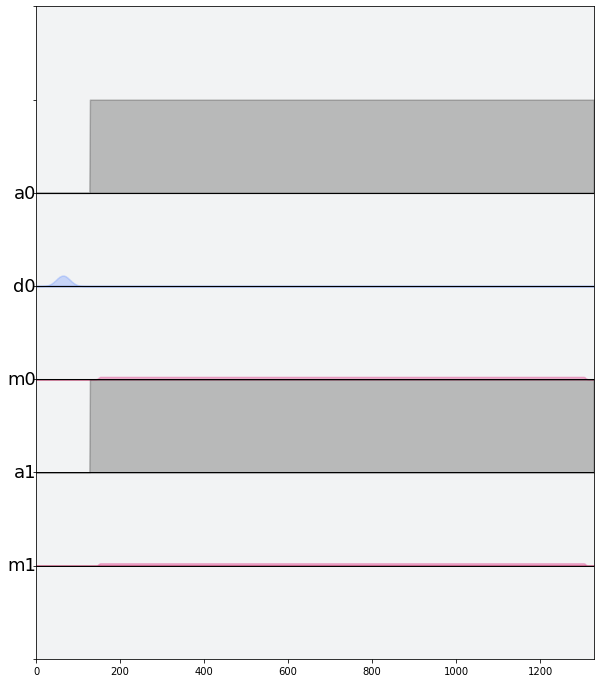

In [7]:
rabi_Q0_experiments = rabi_experiments(qubit=0)

# draw one of the schedules
rabi_Q0_experiments[5].draw()

Next, assemble the `pulse.Schedule` objects for the experiments into a qobj. When assembling, pass the `PulseSimulator` as the backend.

Here, we want to use local oscillators with frequencies automatically computed from Duffing model Hamiltonian.

In [8]:
# instantiate the pulse simulator
backend_sim = PulseSimulator()

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj for a rabi experiment on qubit 0, passing the simulator as the backend
rabi_Q0_qobj = assemble(rabi_Q0_experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/models/pulsedefaults.py:166: UserWarning: `qubit_freq_est` and `meas_freq_est` now have units of Hertz(Hz) rather than gigahertz(GHz).
  warnings.warn('`qubit_freq_est` and `meas_freq_est` now have units of '


Run the simulation and analyze the results:

Pi Amplitude for qubit 0: 0.3106479317008926


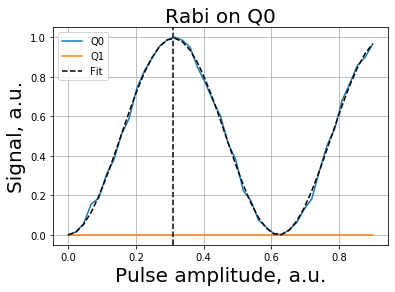

In [9]:
# run the simulation
rabi_Q0_results = backend_sim.run(rabi_Q0_qobj, two_qubit_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q0 = rabi_fit_and_plot(0, rabi_Q0_results)

Plotted is the averaged counts for observing each qubit in the first excited state. Observe that here, qubit 0 oscillates between the 0 and 1 state, whereas qubit 1, which was not driven, remains in the ground state. The amplitude at which qubit 0 is completely in the first excited state is the desired $\pi$ amplitude.

### Repeat the process on qubit 1

Rerun the same commands for qubit 1. Here, when we `assemble`, we won't specify `qubit_lo_freq`. In this situation, the simulator will try to generate it automatically; in this case the only potential source of the local oscillator frequencies is the Hamiltonian itself, so it will automatically be computed from the drift, resulting in the same `qubit_lo_freq` as was specified in the experiments for qubit $0$.

In [10]:
# assemble the qobj for a rabi experiment on qubit 1, passing the simulator as the backend
rabi_Q1_qobj = assemble(rabi_experiments(qubit=1),
                        backend=backend_sim,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

Run the experiments and fit the data.

/Users/dpuzzuoli/anaconda3/envs/QiskitDev/lib/python3.7/site-packages/qiskit/providers/aer/pulse/qobj/digest.py:93: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel, so it is beign automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj or in PulseSystemModel, ' +


Pi Amplitude for qubit 1: 0.3114758141993953


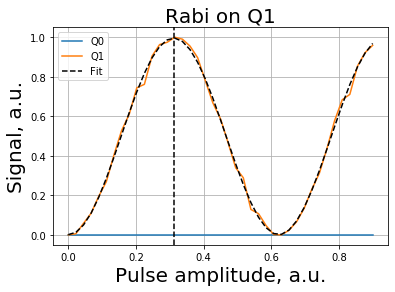

In [11]:
# run the simulation
rabi_Q1_results = backend_sim.run(rabi_Q1_qobj, two_qubit_model).result()

# analyze the data, getting the pi amplitude
pi_amp_Q1 = rabi_fit_and_plot(1, rabi_Q1_results)

We observe similar oscillations, with the roles of qubits 0 and 1 reversed.

## 3. Oscillations from cross-resonance drive

Next, we simulate the effects of a cross-resonance drive on qubit $1$ with target qubit $0$, observing that the trajectory and oscillations of qubit $0$ *depends* on the state of qubit $1$.

**Note:** This section depends on the $\pi$-pulse calibrations of Section 2.

### Cross-resonance `ControlChannel` indices

Driving qubit $1$ at the frequency of qubit $0$ requires use of a pulse `ControlChannel`. The model generating function `duffing_system_model`, automatically sets up `ControlChannels` for performing cross-resonance drives between pairs of coupled qubits. The index of the `ControlChannel` for performing a particular cross-resonance drive is retrievable using the class method `control_channel_index` on the returned `PulseSystemModel`. For example, to get the `ControlChannel` index corresponding to a CR drive on qubit 1 with target 0, call the function `control_channel_index` with the tuple `(1,0)`:

In [12]:
two_qubit_model.control_channel_index((1,0))

1

Hence, to perform a cross-resonance drive on qubit $1$ with target qubit $0$, use `ControlChannel(1)`. This will be made use of when constructing `Schedule` objects in this section.

### Functions to generate the experiment list, and analyze the output

First, we define a function `cr_drive_experiments`, which, given the drive and target indices, and the option to either start with the drive qubit in the ground or excited state, returns a list of experiments for observing the oscillations.

In [13]:
# store the pi amplitudes from Section 2 in a list
pi_amps = [pi_amp_Q0, pi_amp_Q1]

def cr_drive_experiments(drive_idx, 
                         target_idx, 
                         flip_drive_qubit = False,
                         cr_drive_amps=np.linspace(0, 0.9, 41),
                         cr_drive_samples=600,
                         cr_drive_sigma=4,
                         pi_drive_samples=128,
                         pi_drive_sigma=16):
    """Generate schedules corresponding to CR drive experiments.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        flip_drive_qubit (bool): whether or not to start the driven qubit in the ground or excited state
        cr_drive_amps (array): list of drive amplitudes to use
        cr_drive_samples (int): number samples for each CR drive signal
        cr_drive_sigma (float): standard deviation of CR Gaussian pulse
        pi_drive_samples (int): number samples for pi pulse on drive
        pi_drive_sigma (float): standard deviation of Gaussian pi pulse on drive

    Returns:
        list[Schedule]: A list of Schedule objects for each experiment
    """
    
    # Construct measurement commands to be used for all schedules
    meas_amp = 0.025
    meas_samples = 1200
    meas_sigma = 4
    meas_width = 1150
    meas_pulse = GaussianSquare(duration=meas_samples, amp=meas_amp,
                               sigma=meas_sigma, width=meas_width)

    acq_cmd = pulse.Acquire(duration=meas_samples)
    acq_sched = acq_cmd(pulse.AcquireChannel(0), pulse.MemorySlot(0))
    acq_sched += acq_cmd(pulse.AcquireChannel(1), pulse.MemorySlot(1))
    
    # create measurement schedule
    measure_sched = meas_pulse(pulse.MeasureChannel(0)) | meas_pulse(pulse.MeasureChannel(1)) | acq_sched
    
    # Create schedule
    schedules = []
    for ii, cr_drive_amp in enumerate(cr_drive_amps):
        
        # pulse for flipping drive qubit if desired
        pi_pulse = Gaussian(duration=pi_drive_samples, amp=pi_amps[drive_idx], sigma=pi_drive_sigma)

        # cr drive pulse
        cr_width = cr_drive_samples - 2*cr_drive_sigma*4
        cr_rabi_pulse = GaussianSquare(duration=cr_drive_samples, 
                                       amp=cr_drive_amp, 
                                       sigma=cr_drive_sigma,
                                       width=cr_width)

        # add commands to schedule
        schedule = pulse.Schedule(name='cr_rabi_exp_amp_%s' % cr_drive_amp)

        # flip drive qubit if desired
        if flip_drive_qubit:
            schedule += pi_pulse(pulse.DriveChannel(drive_idx))
        
        # do cr drive
        # First, get the ControlChannel index for CR drive from drive to target
        cr_idx = two_qubit_model.control_channel_index((drive_idx, target_idx))
        schedule += cr_rabi_pulse(pulse.ControlChannel(cr_idx))  << schedule.duration
        
        
        schedule += measure_sched << schedule.duration

        schedules.append(schedule)
    return schedules

Next we create two functions for observing the data:
- `plot_cr_pop_data` - for plotting the oscillations in the same style as in Example 1
- `plot_bloch_sphere` - for viewing the trajectory of the target qubit on the bloch sphere

In [14]:
def plot_cr_pop_data(drive_idx, 
                     target_idx, 
                     sim_result, 
                     cr_drive_amps=np.linspace(0, 0.9, 41)):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        target_idx (int): label of target qubit
        sim_result (Result): results of simulation
        cr_drive_amps (array): list of drive amplitudes to use for axis labels
    """
    
    amp_data_Q0 = []
    amp_data_Q1 = []

    for exp_idx in range(len(cr_drive_amps)):
        exp_mem = sim_result.get_memory(exp_idx)
        amp_data_Q0.append(np.abs(exp_mem[0]))
        amp_data_Q1.append(np.abs(exp_mem[1]))

    plt.plot(cr_drive_amps, amp_data_Q0, label='Q0')
    plt.plot(cr_drive_amps, amp_data_Q1, label='Q1')
    plt.legend()
    plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
    plt.ylabel('Signal, a.u.', fontsize=20)
    plt.title('CR (Target Q{0}, driving on Q{1})'.format(target_idx, drive_idx), fontsize=20)
    plt.grid(True)

def bloch_vectors(drive_idx, drive_energy_level, sim_result):
    """Plot the population of each qubit.

    Args:
        drive_idx (int): label of driven qubit
        drive_energy_level (int): energy level of drive qubit at start of CR drive
        sim_result (Result): results of simulation
    
    Returns:
        list: list of Bloch vectors corresponding to the final state of the target qubit
              for each experiment
    """
    
    # get the dim used for simulation
    dim = int(np.sqrt(len(sim_result.get_statevector(0))))
    
    
    # get the relevant dressed state indices
    idx0 = 0
    idx1 = 0
    if drive_idx == 0:
        if drive_energy_level == 0:
            idx0, idx1 = 0, dim
        elif drive_energy_level == 1:
            idx0, idx1 = 1, dim + 1
    if drive_idx == 1:
        if drive_energy_level == 0:
            idx0, idx1 = 0, 1
        elif drive_energy_level == 1:
            idx0, idx1 = dim, dim + 1

    # construct Pauli operators for correct dressed manifold
    state0 = np.array([two_qubit_model.hamiltonian._estates[idx0]])
    state1 = np.array([two_qubit_model.hamiltonian._estates[idx1]])
    
    outer01 = np.transpose(state0)@state1
    outer10 = np.transpose(state1)@state0
    outer00 = np.transpose(state0)@state0
    outer11 = np.transpose(state1)@state1
    
    X = outer01 + outer10
    Y = -1j*outer01 + 1j*outer10
    Z = outer00 - outer11
    
    # function for computing a single bloch vector
    bloch_vec = lambda vec: np.real(np.array([np.conj(vec)@X@vec, np.conj(vec)@Y@vec, np.conj(vec)@Z@vec]))
    
    return [bloch_vec(sim_result.get_statevector(idx)) for idx in range(len(sim_result.results))]

def plot_bloch_sphere(bloch_vectors):
    """Given a list of Bloch vectors, plot them on the Bloch sphere

    Args:
        bloch_vectors (list): list of bloch vectors
    """
    sphere = Bloch()
    sphere.add_points(np.transpose(bloch_vectors))
    sphere.show()

### Drive qubit 1 to observe CR oscillations on qubit 0

#### Qubit 1 in the ground state

First, we drive with both qubit 0 and qubit 1 in the ground state.

In [15]:
# construct experiments
drive_idx = 1
target_idx = 0
flip_drive = False
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

Run the simulation:

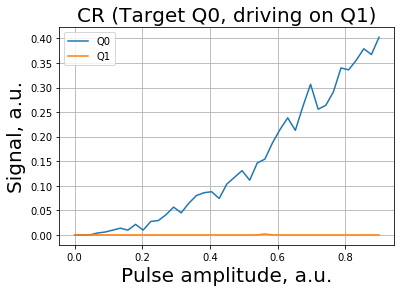

In [16]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

Observe that qubit 1 remains in the ground state, while excitations are driven in qubit 0.

We may also observe the trajectory of qubit 0 on the Bloch sphere:

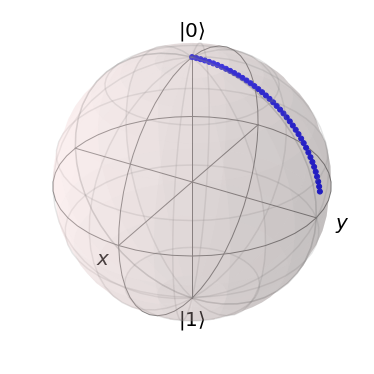

In [17]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

#### Qubit 1 in the first excited state

Next, we again perform a CR drive qubit 1 with qubit 0 as the target, but now we start each experiment by flipping qubit 1 into the first excited state. 

In [18]:
# construct experiments, now with flip_drive == True
drive_idx = 1
target_idx = 0
flip_drive = True
experiments = cr_drive_experiments(drive_idx, target_idx, flip_drive)

# compute frequencies from the Hamiltonian
qubit_lo_freq = two_qubit_model.hamiltonian.get_qubit_lo_from_drift()

# assemble the qobj
cr_rabi_qobj = assemble(experiments,
                        backend=backend_sim,
                        qubit_lo_freq=qubit_lo_freq,
                        meas_level=1, 
                        meas_return='avg',
                        shots=512)

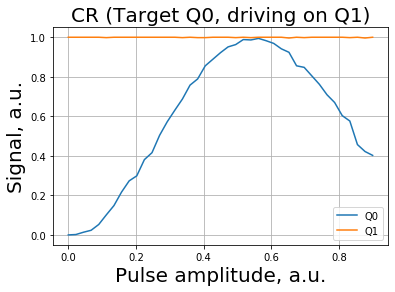

In [19]:
sim_result = backend_sim.run(cr_rabi_qobj, two_qubit_model).result()

plot_cr_pop_data(drive_idx, target_idx, sim_result)

Observe that now qubit 1 is in the excited state, while oscillations are again being driven on qubit 0, now at a different rate as before.

Again, observe the trajectory of qubit 0 on the Bloch sphere:

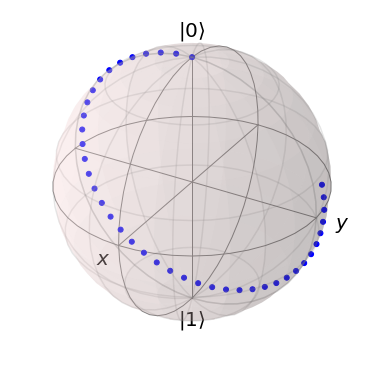

In [20]:
bloch_vecs = bloch_vectors(drive_idx, int(flip_drive), sim_result)
plot_bloch_sphere(bloch_vecs)

Here we see that qubit 0 takes a *different* trajectory on the Bloch sphere when qubit 1 is in the excited state. This is what enables controlled operations between two qubits.